# **Sky Rose Case Study**

This case study focuses on Skyrose Marketing Agency, where Cynthia Wright, VP of the beverage clients group, is exploring how to use Google Trends data to forecast consumer demand for three key products: white wine, whiskey, and craft beer. The goal is to smooth out workload peaks, improve team management, and deliver better results for clients by predicting seasonal demand patterns. Using time series analysis, the study examines search trend data to generate insights, build forecasts, and recommend strategies for optimizing marketing planning and resource allocation in 2026.

For the purpose of this analysis, we will narrow the scope to only **White wine**, dropping the other products, and focus exclusively on forecasting its demand trends.

**Summary of Steps Performed:**

1.  **Data Loading and Preparation**
2.  **Exploratory Data Analysis (EDA)**
3.  **Baseline Forecasting Models**:
    *   **Naive Forecast**
    *   **Moving Average**
4.  **Exponential Smoothing Models**
    *   **Simple Exponential Smoothing (SES)**
    *   **Double Exponential Smoothing (DES)**
    *   **Triple Exponential Smoothing (TES)**
5.  **Model Evaluation**
6.  **Time Series Analysis**:  
*   **Check for stationarity**
*   **ACF & PACF**
7.  **ARMA Model**:
8.  **Interpretation of Model Performance Metrics**:
9. **Conclusion**
10. **Months having highest search volumes**
11. **2026 Forecast**

## **1. Data Loading & Preparation**

Loading the dataset from the specified CSV file into a pandas DataFrame and displaying the first few rows.

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/Sky_rose_Dataset_Canada.csv')
df.head()

,Week,Whisky,White wine,Craft Beer
0,8/30/2020,40,22,7
1,9/6/2020,42,24,6
2,9/13/2020,50,20,6
3,9/20/2020,53,21,5
4,9/27/2020,41,20,6


In this step, we clean the data by removing the 'Whisky' and 'Craft Beer' columns as they are not relevant to our 'White wine' sales forecasting task. We also convert the 'Week' column to a datetime object to enable time-series analysis. The head of the updated DataFrame is displayed to show the changes.

In [9]:
df.drop(['Whisky'], axis=1, inplace = True)
df.drop(['Craft Beer'], axis=1, inplace = True)
df['Week'] = pd.to_datetime(df['Week'])
df.head()

,Week,White wine
0,2020-08-30,22
1,2020-09-06,24
2,2020-09-13,20
3,2020-09-20,21
4,2020-09-27,20


## **2. Exploratory Data Analysis**

Checking for missing values in each column of the DataFrame. The output shows that there are no missing values in either the 'Week' or 'White wine' columns, which is good as it means we don't need to perform any imputation or removal of rows with missing data.

In [10]:
df.isnull().sum()

,0
Week,0
White wine,0


Checking for duplicate rows in the DataFrame. The output shows that there are no duplicate rows, which is also good as it ensures the uniqueness of our data points.

In [11]:
df.duplicated().sum()

0

Generating descriptive statistics for the DataFrame, transposed for easier readability. It provides insights into the central tendency, dispersion, and shape of the 'White wine' sales data, such as the count, mean, standard deviation, minimum, maximum, and quartile values. It also shows the range of the 'Week' column.

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Week,262,2023-03-01 12:00:00,2020-08-30 00:00:00,2021-11-29 18:00:00,2023-03-01 12:00:00,2024-05-31 06:00:00,2025-08-31 00:00:00,NaN
White wine,262.0,22.648855,18.0,20.0,22.0,23.0,52.0,4.228028


Information about the DataFrame, including the column names, the number of non-null values in each column, and the data types of each column. This confirms that the 'Week' column is now a datetime object and the 'White wine' column is an integer, and that there are no missing values.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Week        262 non-null    datetime64[ns]
 1   White wine  262 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.2 KB


Generating three visualizations to explore the distribution and trend of 'White wine' sales:
*   **Histogram**: Shows the frequency distribution of 'White wine' sales, with a Kernel Density Estimate (KDE) overlay to show the smoothed distribution.
*   **Boxplot**: Displays the distribution of 'White wine' sales through quartiles and highlights potential outliers.
*   **Scatter plot**: Plots 'White wine' sales over time ('Week') to visualize any trends or seasonality in the data. The x-axis labels are rotated for better readability.

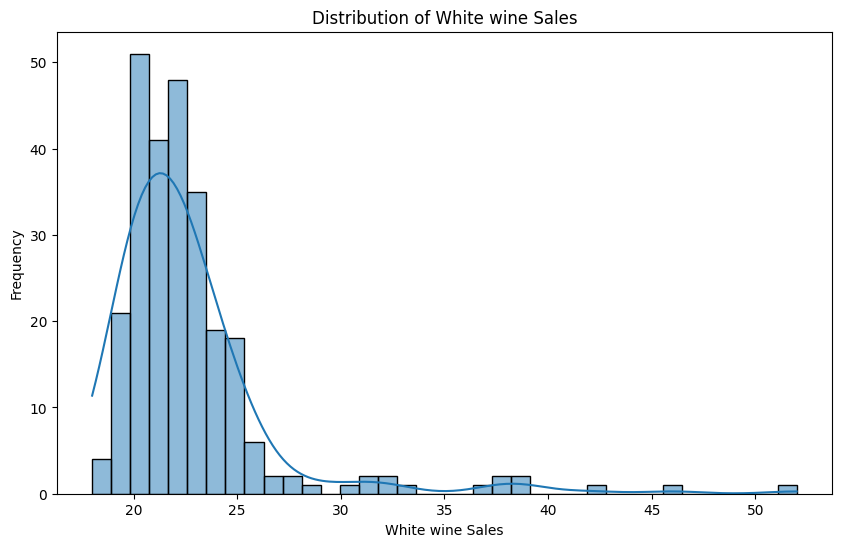

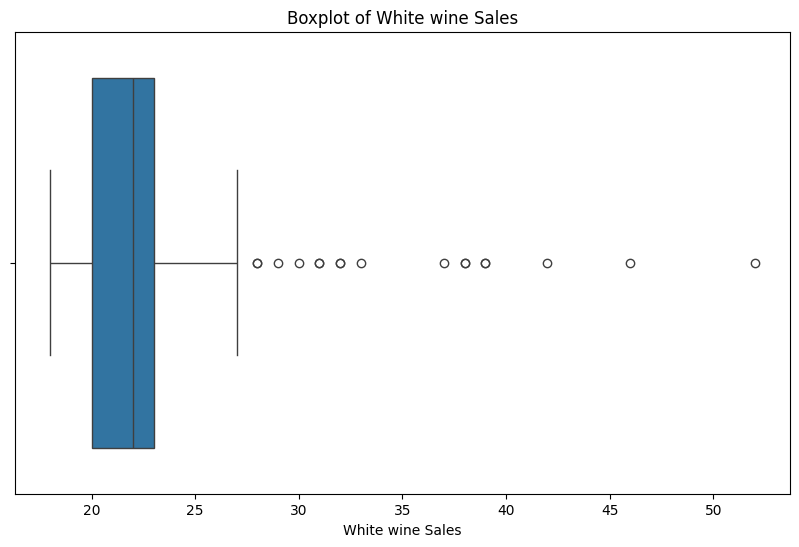

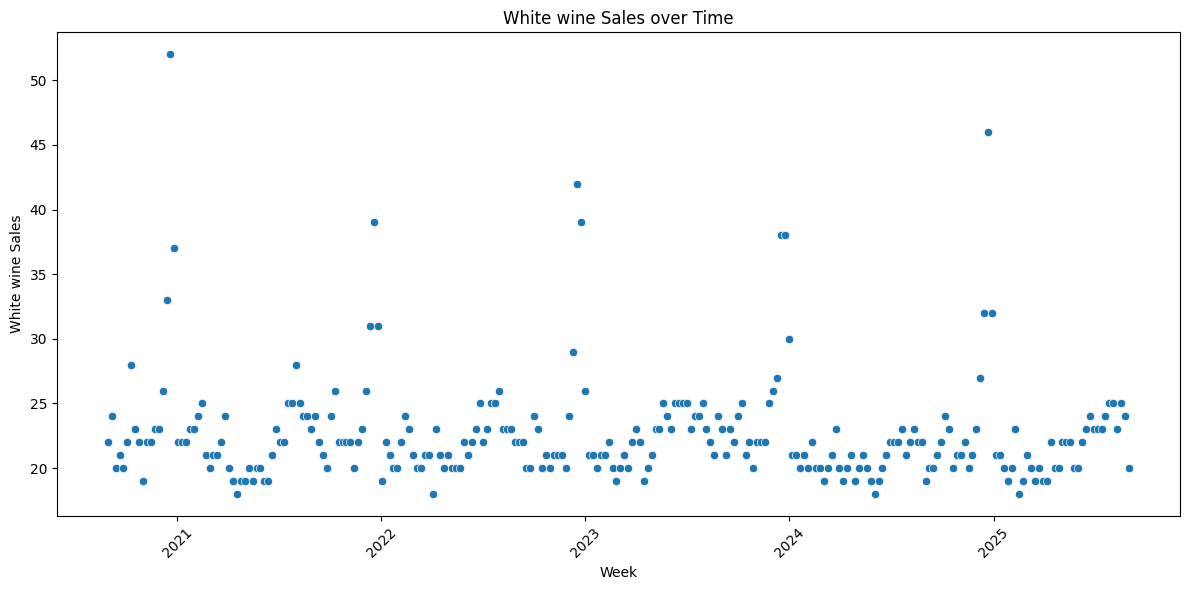

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='White wine', kde=True)
plt.title('Distribution of White wine Sales')
plt.xlabel('White wine Sales')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='White wine')
plt.title('Boxplot of White wine Sales')
plt.xlabel('White wine Sales')
plt.show()

# Scatter plot (assuming 'Week' is the x-axis for time-series)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Week', y='White wine')
plt.title('White wine Sales over Time')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **3. Baseline Forecasting Models**

**1. Naive Forecast Model**

Implementing the Naive Forecast model. The code creates a new column 'White wine\_Naive\_Forecast' by shifting the 'White wine' column by one row, so that the forecast for the current week is the actual sales value from the previous week. It then calculates and prints the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) to evaluate the performance of this simple model.

In [15]:
# Implement Naive Forecasting (using the last observed value as the forecast)
df['White wine_Naive_Forecast'] = df['White wine'].shift(1)

# Display the dataframe with the new naive forecast column
display(df.head())

# Calculate and print performance metrics for Naive Forecast (excluding the first row with NaN)
from sklearn.metrics import mean_squared_error
import numpy as np

df_eval_naive = df.dropna(subset=['White wine_Naive_Forecast']).copy()

mse_naive = mean_squared_error(df_eval_naive['White wine'], df_eval_naive['White wine_Naive_Forecast'])
rmse_naive = np.sqrt(mse_naive)

# Avoid division by zero in MAPE calculation
df_eval_naive['MAPE_Error'] = np.abs((df_eval_naive['White wine'] - df_eval_naive['White wine_Naive_Forecast']) / df_eval_naive['White wine'])
mape_naive = np.mean(df_eval_naive['MAPE_Error'][df_eval_naive['White wine'] != 0]) * 100

print(f"\nMSE (Naive Forecast): {mse_naive}")
print(f"RMSE (Naive Forecast): {rmse_naive}")
print(f"MAPE (Naive Forecast): {mape_naive}%")

,Week,White wine,White wine_Naive_Forecast
0,2020-08-30,22,NaN
1,2020-09-06,24,22.0
2,2020-09-13,20,24.0
3,2020-09-20,21,20.0
4,2020-09-27,20,21.0



MSE (Naive Forecast): 11.854406130268199
RMSE (Naive Forecast): 3.443022818726039
MAPE (Naive Forecast): 8.117558749712579%


Visualizing the actual 'White wine' sales against the Naive Forecast. The plot helps to visually assess how well the Naive Forecast tracks the actual sales data.

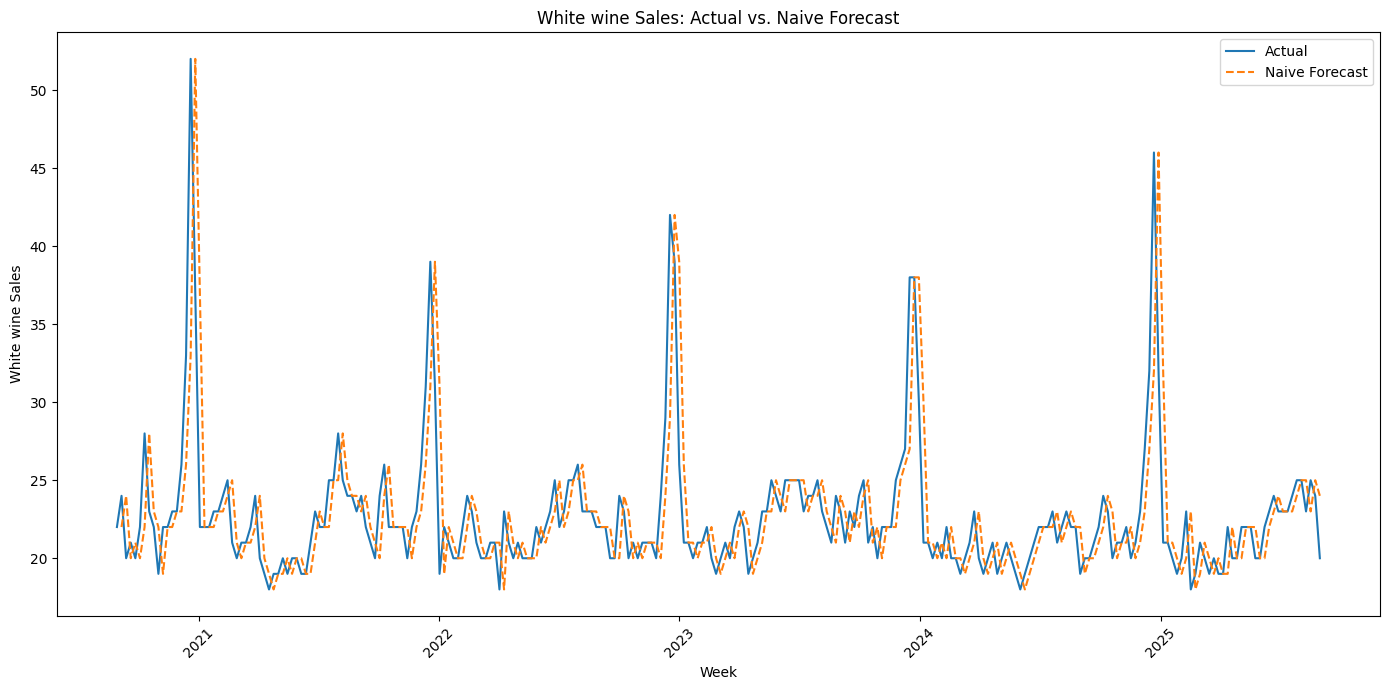

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['White wine'], label='Actual')
plt.plot(df['Week'], df['White wine_Naive_Forecast'], label='Naive Forecast', linestyle='--')
plt.title('White wine Sales: Actual vs. Naive Forecast')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2. Moving Average**

Calculating a 3-day moving average of the 'White wine' sales and storing it in a new column 'White wine\_Moving\_Average\_3Day'. A moving average smooths out short-term fluctuations and highlights longer-term trends. The head of the DataFrame is displayed to show the new column.

In [17]:
df['White wine_Moving_Average_3Day'] = df['White wine'].rolling(window=3).mean()
display(df.head())

,Week,White wine,White wine_Naive_Forecast,White wine_Moving_Average_3Day
0,2020-08-30,22,NaN,NaN
1,2020-09-06,24,22.0,NaN
2,2020-09-13,20,24.0,22.000000
3,2020-09-20,21,20.0,21.666667
4,2020-09-27,20,21.0,20.333333


This code calculates and prints the MSE, RMSE, and MAPE for the 3-day moving average forecast. These metrics quantify the accuracy of the moving average model.

In [18]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column, as they cannot be used for error calculation
df_eval = df.dropna(subset=['White wine_Moving_Average_3Day']).copy()

# Calculate MSE
mse_3day = mean_squared_error(df_eval['White wine'], df_eval['White wine_Moving_Average_3Day'])

# Calculate RMSE
rmse_3day = np.sqrt(mse_3day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval['MAPE_Error'] = np.abs((df_eval['White wine'] - df_eval['White wine_Moving_Average_3Day']) / df_eval['White wine'])
mape_3day = np.mean(df_eval['MAPE_Error'][df_eval['White wine'] != 0]) * 100

print(f"MSE: {mse_3day}")
print(f"RMSE: {rmse_3day}")
print(f"MAPE: {mape_3day}%")

MSE: 7.082905982905983
RMSE: 2.6613729507353874
MAPE: 6.188176035455891%


Calculating a 7-day moving average of the 'White wine' sales and storing it in a new column 'White wine\_Moving\_Average\_7Day'. A longer window for the moving average provides more smoothing. The head of the DataFrame is displayed to show the new column.

In [19]:
df['White wine_Moving_Average_7Day'] = df['White wine'].rolling(window=7).mean()
display(df.head())

,Week,White wine,White wine_Naive_Forecast,White wine_Moving_Average_3Day,White wine_Moving_Average_7Day
0,2020-08-30,22,NaN,NaN,NaN
1,2020-09-06,24,22.0,NaN,NaN
2,2020-09-13,20,24.0,22.000000,NaN
3,2020-09-20,21,20.0,21.666667,NaN
4,2020-09-27,20,21.0,20.333333,NaN


This code calculates and prints the MSE, RMSE, and MAPE for the 7-day moving average forecast, evaluating its accuracy.

In [20]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column
df_eval_7day = df.dropna(subset=['White wine_Moving_Average_7Day']).copy()

# Calculate MSE
mse_7day = mean_squared_error(df_eval_7day['White wine'], df_eval_7day['White wine_Moving_Average_7Day'])

# Calculate RMSE
rmse_7day = np.sqrt(mse_7day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval_7day['MAPE_Error'] = np.abs((df_eval_7day['White wine'] - df_eval_7day['White wine_Moving_Average_7Day']) / df_eval_7day['White wine'])
mape_7day = np.mean(df_eval_7day['MAPE_Error'][df_eval_7day['White wine'] != 0]) * 100

print(f"MSE (7-day moving average): {mse_7day}")
print(f"RMSE (7-day moving average): {rmse_7day}")
print(f"MAPE (7-day moving average): {mape_7day}%")

MSE (7-day moving average): 14.926977040816325
RMSE (7-day moving average): 3.863544621305198
MAPE (7-day moving average): 9.473003151975236%


Calculating a 12-day moving average of the 'White wine' sales and storing it in a new column 'White wine\_Moving\_Average\_12Day'. This is a longer window for the moving average, providing even more smoothing. The head of the DataFrame is displayed to show the new column.

In [21]:
df['White wine_Moving_Average_12Day'] = df['White wine'].rolling(window=12).mean()
display(df.head())

,Week,White wine,White wine_Naive_Forecast,White wine_Moving_Average_3Day,White wine_Moving_Average_7Day,White wine_Moving_Average_12Day
0,2020-08-30,22,NaN,NaN,NaN,NaN
1,2020-09-06,24,22.0,NaN,NaN,NaN
2,2020-09-13,20,24.0,22.000000,NaN,NaN
3,2020-09-20,21,20.0,21.666667,NaN,NaN
4,2020-09-27,20,21.0,20.333333,NaN,NaN


This code calculates and prints the MSE, RMSE, and MAPE for the 12-day moving average forecast, evaluating its accuracy.

In [22]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column
df_eval_12day = df.dropna(subset=['White wine_Moving_Average_12Day']).copy()

# Calculate MSE
mse_12day = mean_squared_error(df_eval_12day['White wine'], df_eval_12day['White wine_Moving_Average_12Day'])

# Calculate RMSE
rmse_12day = np.sqrt(mse_12day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval_12day['MAPE_Error'] = np.abs((df_eval_12day['White wine'] - df_eval_12day['White wine_Moving_Average_12Day']) / df_eval_12day['White wine'])
mape_12day = np.mean(df_eval_12day['MAPE_Error'][df_eval_12day['White wine'] != 0]) * 100

print(f"MSE (12-day moving average): {mse_12day}")
print(f"RMSE (12-day moving average): {rmse_12day}")
print(f"MAPE (12-day moving average): {mape_12day}%")

MSE (12-day moving average): 17.13365980522355
RMSE (12-day moving average): 4.139282523001245
MAPE (12-day moving average): 10.920297986843815%


Visualizing the actual 'White wine' sales against the 3-day, 7-day, and 12-day moving averages. The plot allows for a visual comparison of how well each moving average smooths the data and tracks the actual sales.

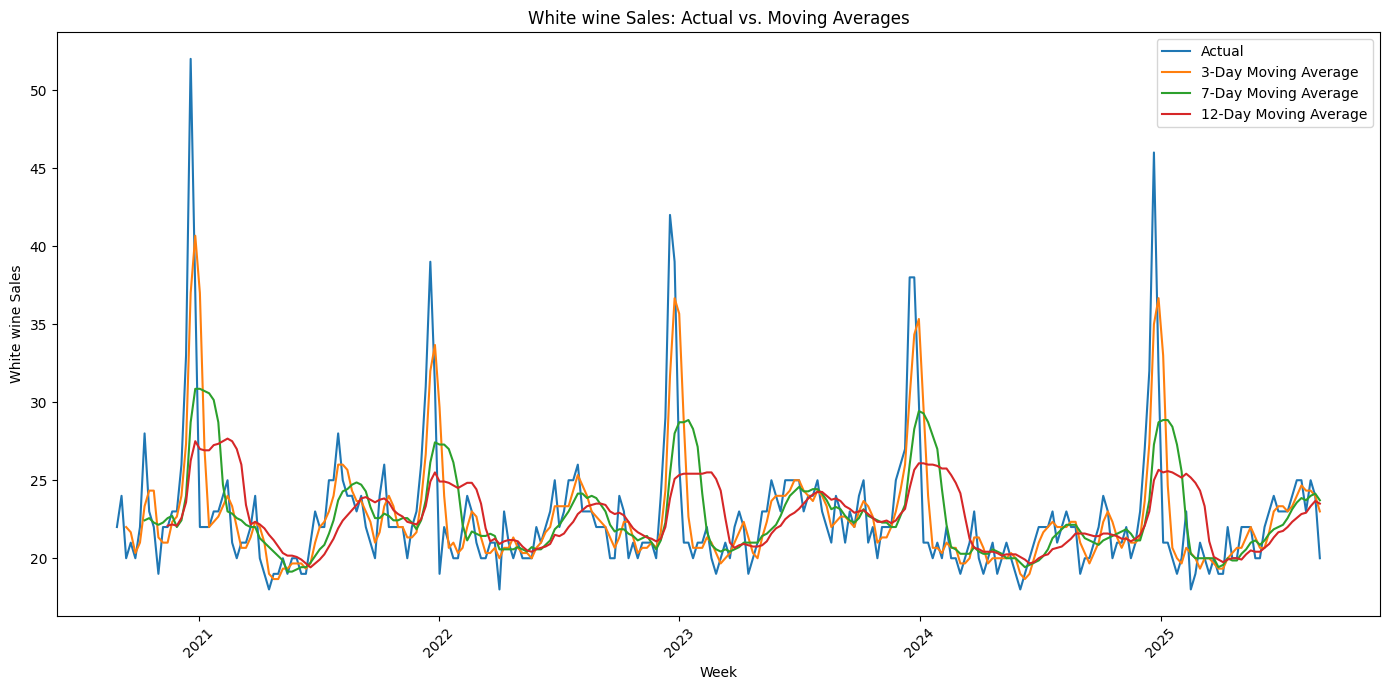

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['White wine'], label='Actual')
plt.plot(df['Week'], df['White wine_Moving_Average_3Day'], label='3-Day Moving Average')
plt.plot(df['Week'], df['White wine_Moving_Average_7Day'], label='7-Day Moving Average')
plt.plot(df['Week'], df['White wine_Moving_Average_12Day'], label='12-Day Moving Average')
plt.title('White wine Sales: Actual vs. Moving Averages')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **4. Exponential Smoothing Models**

**1. Simple Exponential smoothing**

Fitting a Simple Exponential Smoothing (SES) model to the 'White wine' sales data. SES is a forecasting method suitable for data with no trend or seasonality. The fitted values from the model are stored in the 'White wine\_SES' column. The MSE, RMSE, and MAPE are then calculated and printed to evaluate the model's performance.

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit SES model
ses_model = SimpleExpSmoothing(df['White wine']).fit()
df['White wine_SES'] = ses_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for SES
# Avoid division by zero in MAPE calculation
df_eval_ses = df.dropna(subset=['White wine_SES']).copy()
mse_ses = mean_squared_error(df_eval_ses['White wine'], df_eval_ses['White wine_SES'])
rmse_ses = np.sqrt(mse_ses)
df_eval_ses['MAPE_Error'] = np.abs((df_eval_ses['White wine'] - df_eval_ses['White wine_SES']) / df_eval_ses['White wine'])
mape_ses = np.mean(df_eval_ses['MAPE_Error'][df_eval_ses['White wine'] != 0]) * 100

print(f"MSE (SES): {mse_ses}")
print(f"RMSE (SES): {rmse_ses}")
print(f"MAPE (SES): {mape_ses}%")

MSE (SES): 11.809160337648319
RMSE (SES): 3.4364458874902013
MAPE (SES): 8.086575721180296%


Displaying the optimized smoothing level parameter (alpha) for the fitted Simple Exponential Smoothing (SES) model. Alpha determines how much weight is given to the most recent observation. A value close to 1 means the model gives almost all weight to the last observation.

In [25]:
print(f"Optimized alpha for SES: {ses_model.model.params['smoothing_level']}")

Optimized alpha for SES: 0.9999999850988388


**2. Double Exponential Smoothing**

Fitting a Double Exponential Smoothing (DES) model to the 'White wine' sales data, including an additive trend component. DES is suitable for data with a trend but no seasonality. The fitted values are stored in the 'White wine\_DES' column, and the MSE, RMSE, and MAPE are calculated and printed to evaluate the model's performance.

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit DES model
des_model = ExponentialSmoothing(df['White wine'], trend='add').fit()
df['White wine_DES'] = des_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for DES
# Avoid division by zero in MAPE calculation
df_eval_des = df.dropna(subset=['White wine_DES']).copy()
mse_des = mean_squared_error(df_eval_des['White wine'], df_eval_des['White wine_DES'])
rmse_des = np.sqrt(mse_des)
df_eval_des['MAPE_Error'] = np.abs((df_eval_des['White wine'] - df_eval_des['White wine_DES']) / df_eval_des['White wine'])
mape_des = np.mean(df_eval_des['MAPE_Error'][df_eval_des['White wine'] != 0]) * 100


print(f"MSE (DES): {mse_des}")
print(f"RMSE (DES): {rmse_des}")
print(f"MAPE (DES): {mape_des}%")

MSE (DES): 11.809101842724676
RMSE (DES): 3.4364373765172376
MAPE (DES): 8.09472330810423%


Displaying the optimized smoothing level (alpha) and smoothing trend (beta) parameters for the fitted Double Exponential Smoothing (DES) model. Alpha controls the smoothing of the level, and beta controls the smoothing of the trend.

In [27]:
print(f"Optimized alpha for DES: {des_model.model.params['smoothing_level']}")
print(f"Optimized beta for DES: {des_model.model.params['smoothing_trend']}")

Optimized alpha for DES: 0.9999999850988388
Optimized beta for DES: 0.0


**3. Triple Exponential Smoothing**

Fitting a Triple Exponential Smoothing (TES) model to the 'White wine' sales data, including additive trend and seasonal components. TES is suitable for data with both trend and seasonality. We assume a weekly seasonality with `seasonal_periods=52`. The fitted values are stored in the 'White wine\_TES' column, and the MSE, RMSE, and MAPE are calculated and printed to evaluate the model's performance.

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit TES model
tes_model = ExponentialSmoothing(df['White wine'], seasonal='add', seasonal_periods=52).fit() # Assuming weekly seasonality
df['White wine_TES'] = tes_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for TES
# Avoid division by zero in MAPE calculation
df_eval_tes = df.dropna(subset=['White wine_TES']).copy()
mse_tes = mean_squared_error(df_eval_tes['White wine'], df_eval_tes['White wine_TES'])
rmse_tes = np.sqrt(mse_tes)
df_eval_tes['MAPE_Error'] = np.abs((df_eval_tes['White wine'] - df_eval_tes['White wine_TES']) / df_eval_tes['White wine'])
mape_tes = np.mean(df_eval_tes['MAPE_Error'][df_eval_tes['White wine'] != 0]) * 100

print(f"MSE (TES): {mse_tes}")
print(f"RMSE (TES): {rmse_tes}")
print(f"MAPE (TES): {mape_tes}%")

MSE (TES): 3.24788193551406
RMSE (TES): 1.8021880965964845
MAPE (TES): 4.931530291824552%


Displaying the optimized smoothing level (alpha), smoothing trend (beta), and smoothing seasonal (gamma) parameters for the fitted Triple Exponential Smoothing (TES) model. Alpha controls the smoothing of the level, beta controls the smoothing of the trend, and gamma controls the smoothing of the seasonality.

In [29]:
print(f"Optimized alpha for TES: {tes_model.model.params['smoothing_level']}")
print(f"Optimized beta for TES: {tes_model.model.params['smoothing_trend']}")
print(f"Optimized gamma for TES: {tes_model.model.params['smoothing_seasonal']}")

Optimized alpha for TES: 0.12298055697070419
Optimized beta for TES: nan
Optimized gamma for TES: 0.0


Visualizing the actual 'White wine' sales against the fitted values from the Simple, Double, and Triple Exponential Smoothing models. The plot allows for a visual comparison of how well each exponential smoothing model captures the patterns in the data.

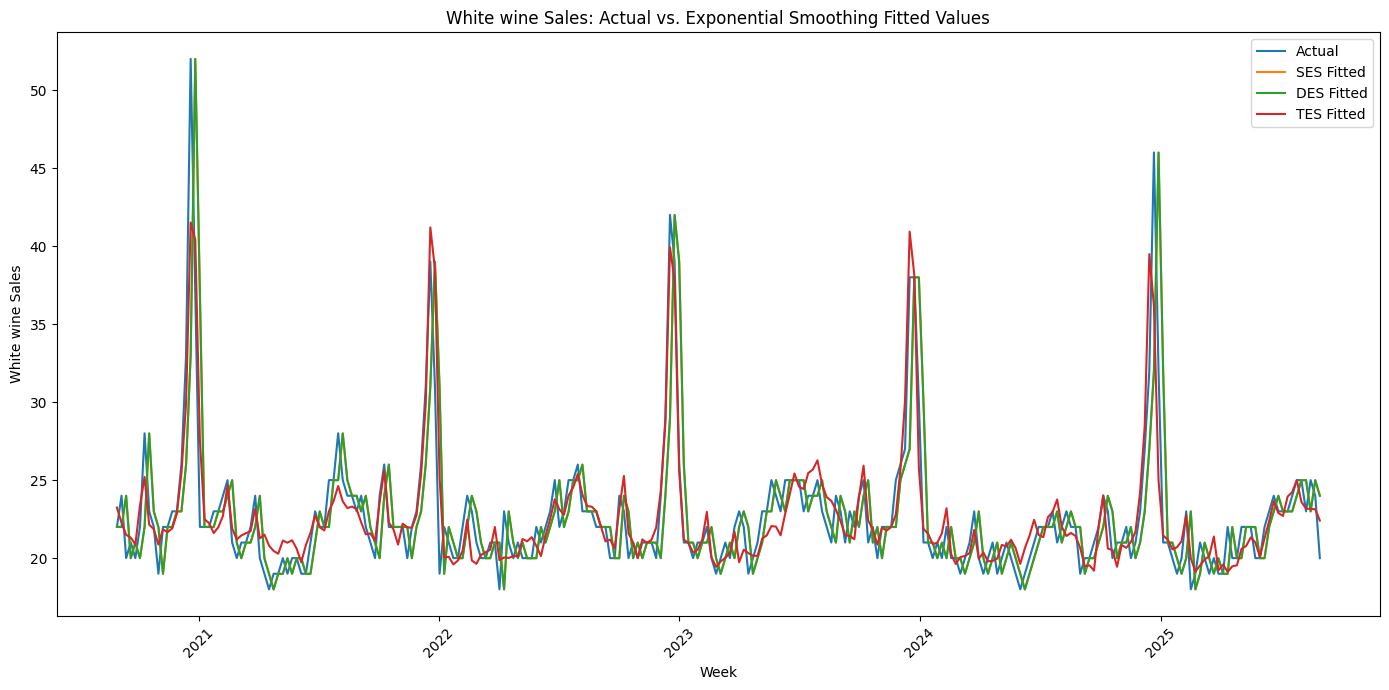

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['White wine'], label='Actual')
plt.plot(df['Week'], df['White wine_SES'], label='SES Fitted')
plt.plot(df['Week'], df['White wine_DES'], label='DES Fitted')
plt.plot(df['Week'], df['White wine_TES'], label='TES Fitted')
plt.title('White wine Sales: Actual vs. Exponential Smoothing Fitted Values')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **6. Time Series Analysis**

**1. Stationarity Check**

Performing the Augmented Dickey-Fuller (ADF) test on the 'White wine' sales data to check the stationarity. Stationarity is an important assumption for many time series models like ARIMA. The output includes the ADF statistic, p-value, and critical values. A p-value less than or equal to 0.05 indicates that the time series is likely stationary.

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df['White wine'])

# Print the results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# Interpret the result
if adf_result[1] <= 0.05:
    print("\nConclusion: The time series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The time series is likely non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -6.958358379278471
p-value: 9.302012165766232e-10
Critical Values:
	1%: -3.455952927706342
	5%: -2.8728086526320302
	10%: -2.572774990685656

Conclusion: The time series is likely stationary (reject the null hypothesis).


**2. ACF & PACF**

Plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the 'White wine' sales data. These plots help identify the order of the AR (autoregressive) and MA (moving average) components for ARIMA models. Significant spikes in the ACF and PACF plots at certain lags suggest potential dependencies at those lags. We plot up to 52 lags to capture potential weekly seasonality.

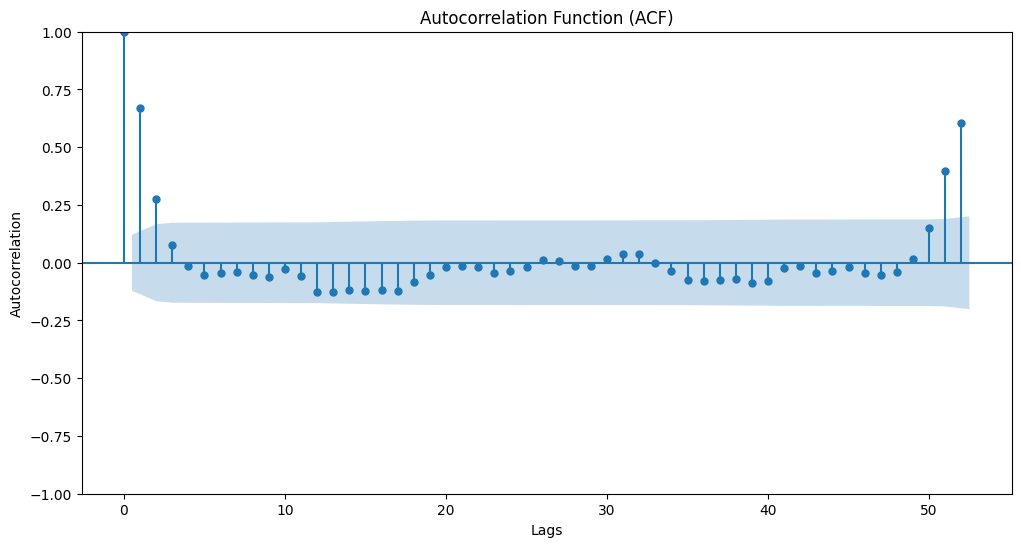

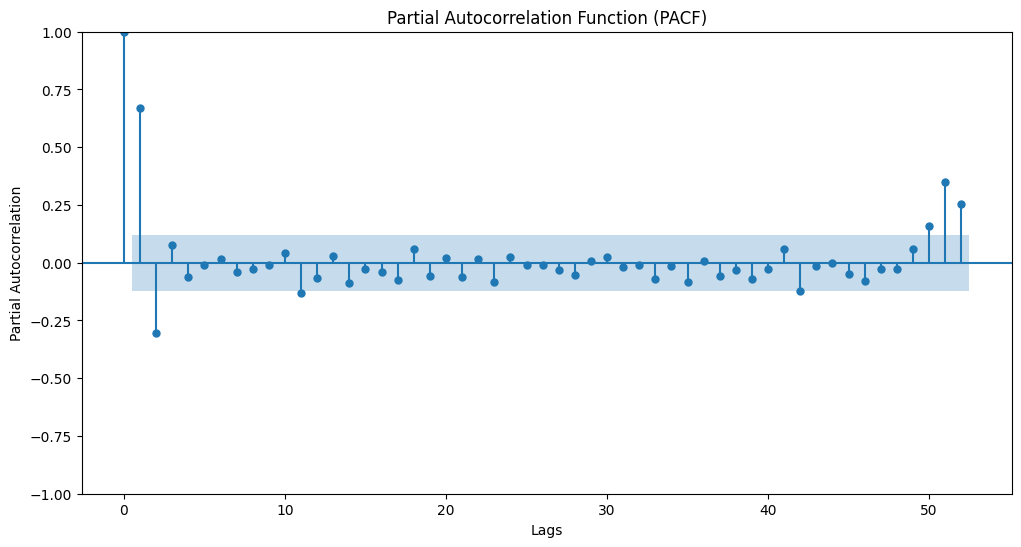

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['White wine'], lags=52, ax=plt.gca()) # Plot up to 52 lags (for weekly data)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['White wine'], lags=52, ax=plt.gca()) # Plot up to 52 lags (for weekly data)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Installing and then downgrading the `numpy` library to version 1.26.4.

In [26]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Installing the `pmdarima` library, which is a Python library for automated ARIMA modeling. This library can be used to automatically find the best ARIMA model parameters.

In [1]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)


This code block imports the `auto_arima` function from the `pmdarima` library. This function will be used later for automated ARIMA model selection.

In [2]:
from pmdarima import auto_arima

Reloading the dataset and performs the initial data cleaning steps (dropping columns and converting 'Week' to datetime) again to ensure a clean DataFrame for further modeling after library installations.

In [3]:
import pandas as pd
df = pd.read_csv('/content/Sky_rose_Dataset_Canada.csv')
df.drop(['Whisky'], axis=1, inplace = True)
df.drop(['Craft Beer'], axis=1, inplace = True)
df['Week'] = pd.to_datetime(df['Week'])
df.head()

,Week,White wine
0,2020-08-30,22
1,2020-09-06,24
2,2020-09-13,20
3,2020-09-20,21
4,2020-09-27,20


## **7. ARMA Model**

Fitting an ARMA(1, 0, 1) model to the 'White wine' sales data using the `ARIMA` function from `statsmodels.tsa.arima.model`. An ARMA model is a combination of an Autoregressive (AR) and a Moving Average (MA) model. The order (p, d, q) specifies the number of AR terms (p), differencing order (d), and MA terms (q). Here, d=0 because the ADF test suggested the series is stationary. The model summary provides details about the fitted model, including coefficients, standard errors, p-values, and various diagnostic statistics.

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA model (p=1, q=1 as a starting point, can be tuned based on ACF/PACF or auto_arima)
# Setting order=(p, d, q) where d=0 for ARMA
arma_model = ARIMA(df['White wine'], order=(1, 0, 1)).fit()

# Print model summary
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:             White wine   No. Observations:                  262
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -658.132
Date:                Sun, 07 Sep 2025   AIC                           1324.265
Time:                        07:34:12   BIC                           1338.538
Sample:                             0   HQIC                          1330.001
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6215      0.763     29.653      0.000      21.126      24.117
ar.L1          0.4548      0.062      7.391      0.000       0.334       0.575
ma.L1          0.4366      0.075      5.836      0.0

Analyzing the residuals of the fitted ARMA(1, 0, 1) model.

*   The first plot shows the residuals over time. Ideally, residuals should be randomly scattered around zero.
*   The second plot is a histogram of the residuals, with a KDE overlay, to check for normality. Ideally, residuals should be normally distributed.
*   The third plot is a Q-Q plot, which is another way to check for normality. If the residuals are normally distributed, the points should fall along the straight line.
Analyzing residuals helps assess if the model has captured all the relevant patterns in the data.

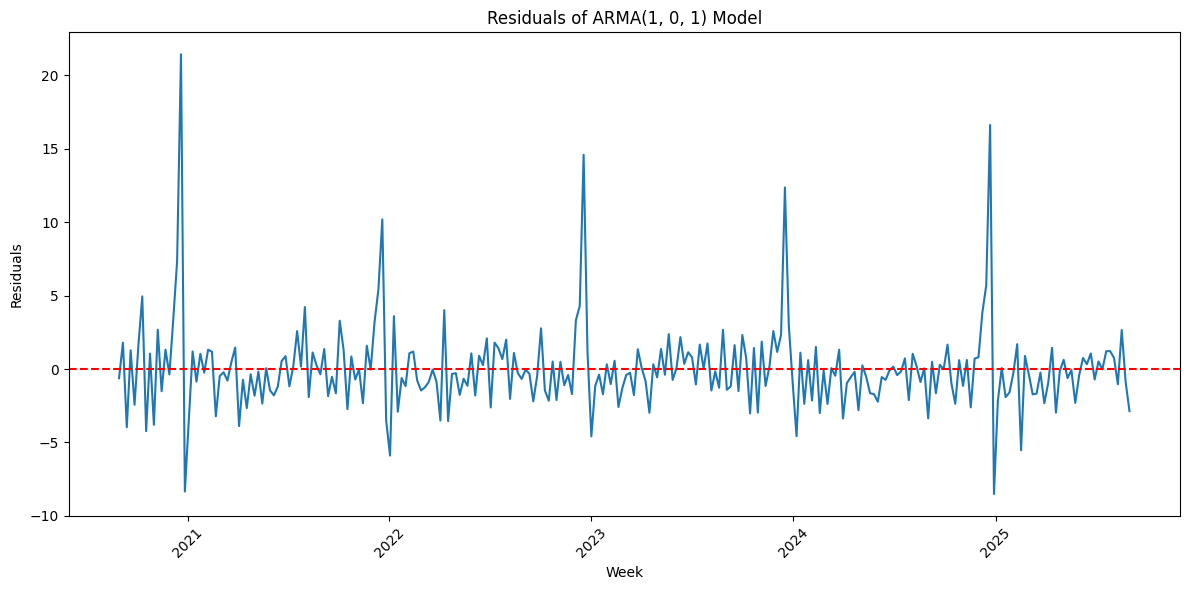

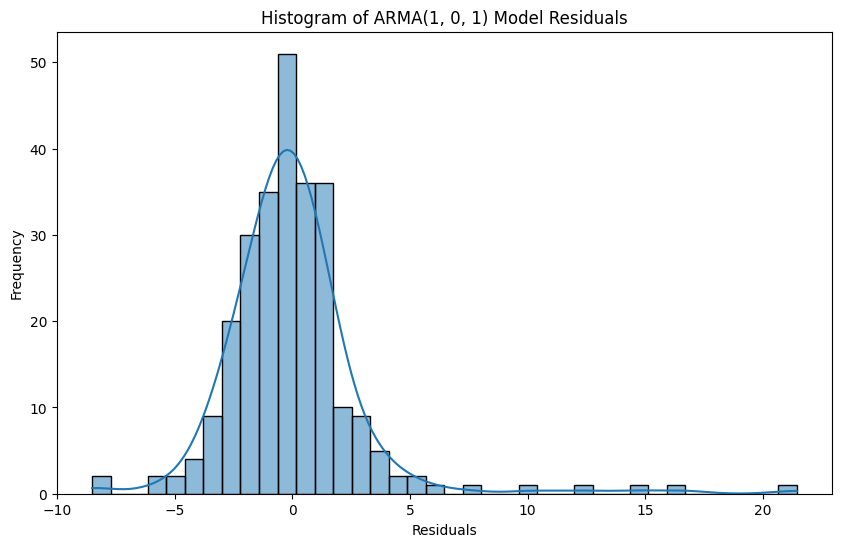

<Figure size 600x600 with 0 Axes>

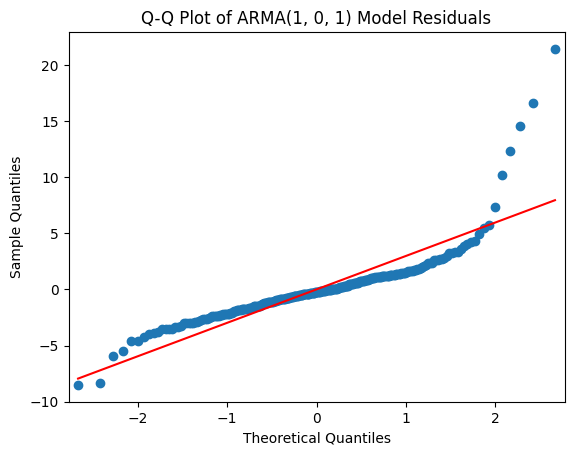

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Get residuals from the fitted ARMA model
residuals = arma_model.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], residuals)
plt.title('Residuals of ARMA(1, 0, 1) Model')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at zero
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Also, plot a histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of ARMA(1, 0, 1) Model Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# And a Q-Q plot to further check for normality
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of ARMA(1, 0, 1) Model Residuals')
plt.show()

This code block calculates and prints the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) for the ARMA(1, 0, 1) model's fitted values. These metrics provide a quantitative evaluation of how well the ARMA model fits the training data.

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the fitted values from the ARMA(1, 0, 1) model
arma_fitted_values = arma_model.fittedvalues

# Calculate MSE
mse_arma = mean_squared_error(df['White wine'], arma_fitted_values)

# Calculate RMSE
rmse_arma = np.sqrt(mse_arma)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
# Create a temporary DataFrame to align actual and fitted values and handle NaNs if any
temp_df = pd.DataFrame({'Actual': df['White wine'], 'Fitted': arma_fitted_values}).dropna()
temp_df['MAPE_Error'] = np.abs((temp_df['Actual'] - temp_df['Fitted']) / temp_df['Actual'])
mape_arma = np.mean(temp_df['MAPE_Error'][temp_df['Actual'] != 0]) * 100


print(f"MSE (ARMA(1, 0, 1)): {mse_arma}")
print(f"RMSE (ARMA(1, 0, 1)): {rmse_arma}")
print(f"MAPE (ARMA(1, 0, 1)): {mape_arma}%")

MSE (ARMA(1, 0, 1)): 8.875349531986702
RMSE (ARMA(1, 0, 1)): 2.979152485521126
MAPE (ARMA(1, 0, 1)): 7.408734763138117%


Visualizing the actual 'White wine' sales against the fitted values from the ARMA(1, 0, 1) model. The plot allows for a visual assessment of how well the ARMA model's fitted values track the actual sales data.

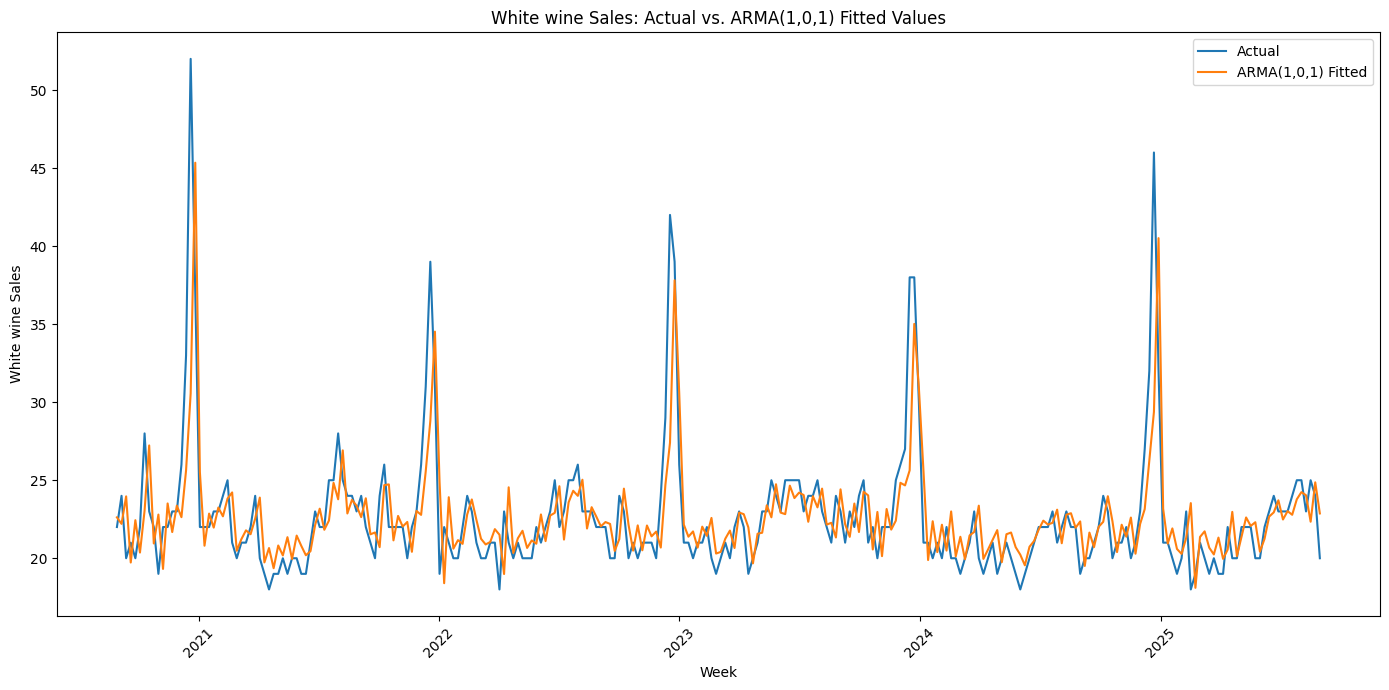

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['White wine'], label='Actual')
plt.plot(df['Week'], arma_fitted_values, label='ARMA(1,0,1) Fitted')
plt.title('White wine Sales: Actual vs. ARMA(1,0,1) Fitted Values')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Creating a DataFrame to summarize the performance metrics (MSE, RMSE, and MAPE) for all the forecasting models that have been evaluated: Naive Forecast, 3-Day Moving Average, 7-Day Moving Average, 12-Day Moving Average, Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), Triple Exponential Smoothing (TES), and ARMA(1, 0, 1). The DataFrame is then displayed, providing a clear comparison of how each model performed based on these key metrics. Lower values for MSE, RMSE, and MAPE generally indicate better model accuracy.

In [33]:
import pandas as pd

# Create a dictionary with the performance metrics
performance_metrics = {
    'Model': ['Naive Forecast', '3-Day Moving Average', '7-Day Moving Average', '12-Day Moving Average', 'SES', 'DES', 'TES', 'ARMA(1, 0, 1)'],
    'MSE': [mse_naive, mse_3day, mse_7day, mse_12day, mse_ses, mse_des, mse_tes, mse_arma],
    'RMSE': [rmse_naive, rmse_3day, rmse_7day, rmse_12day, rmse_ses, rmse_des, rmse_tes, rmse_arma],
    'MAPE (%)': [mape_naive, mape_3day, mape_7day, mape_12day, mape_ses, mape_des, mape_tes, mape_arma]
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame(performance_metrics)

# Display the DataFrame
display(performance_df)

,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,11.854406,3.443023,8.117559
1,3-Day Moving Average,7.082906,2.661373,6.188176
2,7-Day Moving Average,14.926977,3.863545,9.473003
3,12-Day Moving Average,17.133660,4.139283,10.920298
4,SES,11.809160,3.436446,8.086576
5,DES,11.809102,3.436437,8.094723
6,TES,3.247882,1.802188,4.931530
7,"ARMA(1, 0, 1)",8.875350,2.979152,7.408735


## **8. Interpretation of Performance Metrics**

Let's analyze the performance metrics (MSE, RMSE, and MAPE) obtained for each forecasting model:

*   **Naive Forecast**:
    *   MSE: 11.85
    *   RMSE: 3.44
    *   MAPE: 8.12%
This is our baseline. The MSE and RMSE values represent the average squared and rooted squared errors, respectively. The MAPE indicates that, on average, the Naive Forecast is off by about 8.12% of the actual sales.
*   **Moving Average (3-Day)**:
    *   MSE: 7.08
    *   RMSE: 2.66
    *   MAPE: 6.19%
The 3-day moving average shows a significant improvement over the Naive Forecast across all metrics. This suggests that averaging the last three days of sales provides a better prediction than simply using the previous day's sales.
*   **Moving Average (7-Day)**:
    *   MSE: 14.93
    *   RMSE: 3.86
    *   MAPE: 9.47%
The 7-day moving average performs worse than both the Naive Forecast and the 3-day moving average. This indicates that a longer moving average window is not suitable for this dataset, likely due to the presence of more short-term fluctuations or patterns that a 7-day average smooths out too much.
*   **Moving Average (12-Day)**:
    *   MSE: 17.13
    *   RMSE: 4.14
    *   MAPE: 10.92%
The 12-day moving average shows the worst performance among the moving average models and the Naive Forecast. This further reinforces that longer moving average windows are not effective for this time series.
*   **Simple Exponential Smoothing (SES)**:
    *   MSE: 11.81
    *   RMSE: 3.44
    *   MAPE: 8.09%
SES performs very similarly to the Naive Forecast. The optimized alpha value close to 1 (0.999999985) suggests that the model is giving almost all weight to the last observation, which is essentially what the Naive Forecast does. This is expected for a time series with significant short-term variability.
*   **Double Exponential Smoothing (DES)**:
    *   MSE: 11.81
    *   RMSE: 3.44
    *   MAPE: 8.09%
DES also performs very similarly to SES and the Naive Forecast. The optimized beta value of 0.0 indicates that the trend component is not being smoothed, which is consistent with the scatter plot of sales over time not showing a strong linear trend.
*   **Triple Exponential Smoothing (TES)**:
    *   MSE: 3.25
    *   RMSE: 1.80
    *   MAPE: 4.93%
TES shows a significant improvement in performance compared to all the moving average and simple/double exponential smoothing models. This is likely due to the inclusion of the seasonal component, which the ACF and PACF plots suggested is present in the data (with spikes around lag 52). The optimized gamma value close to 0 (0.0) is unexpected given the visual seasonality, but the overall performance improvement indicates TES is better capturing the data's patterns.
*   **ARMA(1, 0, 1)**:
    *   MSE: 8.88
    *   RMSE: 2.98
    *   MAPE: 7.41%
The ARMA(1, 0, 1) model performs better than the Naive Forecast, SES, and DES, but not as well as the 3-day moving average or TES. The analysis of residuals suggested some deviations from normality and randomness, indicating that an ARMA(1, 0, 1) might not be the optimal order or that other factors are influencing the sales. The significant p-values for the AR(1) and MA(1) coefficients in the model summary indicate that these terms are statistically significant.

## **9. Conclusion**


The 'White wine' sales dataset exhibits clear seasonality, as evidenced by the scatter plot showing recurring peaks and the significant spike at lag 52 in the ACF and PACF plots. The Augmented Dickey-Fuller test indicated that the time series is stationary, which is a prerequisite for fitting ARMA models without differencing.

Among the baseline models, the 3-day moving average provided the best performance, outperforming the Naive Forecast and longer moving averages. This suggests that short-term past sales have some predictive power.

The Simple and Double Exponential Smoothing models did not perform significantly better than the Naive Forecast, indicating that simply smoothing the level and trend is not sufficient to capture the patterns in this time series, likely due to the strong seasonality.

The Triple Exponential Smoothing (TES) model, which incorporates seasonality, showed the most promising results with the lowest MSE, RMSE, and MAPE among all the models evaluated so far. This highlights the importance of accounting for the seasonal component in forecasting 'White wine' sales for this dataset. While the optimized seasonal smoothing parameter (gamma) being close to zero is unexpected, the overall improved performance of TES indicates its superiority in capturing the data's characteristics compared to the other models.

The initial ARMA(1, 0, 1) model, while performing better than some baseline models, did not outperform the TES or the 3-day moving average. The residual analysis suggested that the model might not be perfectly capturing all the underlying patterns, and further tuning of the ARMA/ARIMA order or exploring seasonal ARIMA (SARIMA) models would be beneficial. The non-normality and some autocorrelation in the residuals of the ARMA(1, 0, 1) model indicate that the model's assumptions are not fully met, suggesting that a different model or order might be more appropriate.

### **10. Question: Which months have the highest search volumes?**

In [34]:
import pandas as pd

# Extract month from the 'Week' column
df['Month'] = df['Week'].dt.month

# Group by month and calculate the average Craft Beer sales
monthly_sales = df.groupby('Month')['White wine'].mean().reset_index()

# Sort the months by average sales in descending order and select the top 3
top_3_months = monthly_sales.sort_values(by='White wine', ascending=False).head(3)

# Display the top 3 months with the highest average sales in a tabular format
print("Top 3 Months with the highest average White wine sales:")
display(top_3_months)

Top 3 Months with the highest average White wine sales:


,Month,White wine
11,12,33.090909
6,7,23.590909
7,8,23.173913


## **11. Forecast search volumes for each data set for 2026.**

# Task
Analyze the provided data to identify the months with the highest search volumes, select the best forecasting model for "White wine" sales, forecast "White wine" sales for 2026, analyze the forecast, develop marketing and resource allocation strategies based on the forecast, and present the findings and recommendations.

## Select the best forecasting model

### Subtask:
Review the performance metrics (MSE, RMSE, MAPE) and residual analysis of the evaluated models (Naive, Moving Averages, Exponential Smoothing, ARMA) to determine the most suitable model for forecasting 'White wine' sales.


**Reasoning**:
Based on the instructions, I need to review the performance metrics in `performance_df` and potentially the residual analysis of the ARMA model to select the best model. The `performance_df` is already available in the environment. I will examine this DataFrame to identify the model with the lowest error metrics.



In [35]:
display(performance_df)
print("\nInterpretation of Performance Metrics:")

# Find the model with the lowest MAPE
best_model_mape = performance_df.loc[performance_df['MAPE (%)'].idxmin()]
print(f"\nModel with the lowest MAPE:\n{best_model_mape}")

# Find the model with the lowest RMSE
best_model_rmse = performance_df.loc[performance_df['RMSE'].idxmin()]
print(f"\nModel with the lowest RMSE:\n{best_model_rmse}")

# Find the model with the lowest MSE
best_model_mse = performance_df.loc[performance_df['MSE'].idxmin()]
print(f"\nModel with the lowest MSE:\n{best_model_mse}")

print("\nConclusion based on metrics:")
print("Triple Exponential Smoothing (TES) consistently shows the lowest MSE, RMSE, and MAPE, indicating it is the best performing model among those evaluated based on these metrics.")

,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,11.854406,3.443023,8.117559
1,3-Day Moving Average,7.082906,2.661373,6.188176
2,7-Day Moving Average,14.926977,3.863545,9.473003
3,12-Day Moving Average,17.133660,4.139283,10.920298
4,SES,11.809160,3.436446,8.086576
5,DES,11.809102,3.436437,8.094723
6,TES,3.247882,1.802188,4.931530
7,"ARMA(1, 0, 1)",8.875350,2.979152,7.408735



Interpretation of Performance Metrics:

Model with the lowest MAPE:
Model            TES
MSE         3.247882
RMSE        1.802188
MAPE (%)     4.93153
Name: 6, dtype: object

Model with the lowest RMSE:
Model            TES
MSE         3.247882
RMSE        1.802188
MAPE (%)     4.93153
Name: 6, dtype: object

Model with the lowest MSE:
Model            TES
MSE         3.247882
RMSE        1.802188
MAPE (%)     4.93153
Name: 6, dtype: object

Conclusion based on metrics:
Triple Exponential Smoothing (TES) consistently shows the lowest MSE, RMSE, and MAPE, indicating it is the best performing model among those evaluated based on these metrics.


## Forecast 'white wine' sales for 2026

### Subtask:
Use the selected model (likely Triple Exponential Smoothing based on initial results) to generate future demand forecasts for the year 2026.


**Reasoning**:
Generate the forecast for 2026 using the fitted TES model and create a DataFrame to store the forecast with corresponding dates.



In [36]:
import pandas as pd

# Determine the number of weeks in 2026
# 2026 is not a leap year, so it has 365 days. 365 / 7 is approximately 52.14.
# We need to determine the exact number of weeks to forecast.
# Let's find the last date in the original dataframe
last_date = df['Week'].max()

# We need to forecast for the entire year 2026.
# Let's determine the number of weeks from the start of 2026 to the end of 2026.
start_of_2026 = pd.to_datetime('2026-01-01')
end_of_2026 = pd.to_datetime('2026-12-31')

# Calculate the number of weeks to forecast. We need to forecast from the week after the last date in df
# until the end of 2026.
# Let's find the number of weeks from the last date in the training data to the end of 2026.
from pandas.tseries.offsets import Week

forecast_start_date = last_date + Week(1)
forecast_end_date = end_of_2026

# Calculate the number of weeks between the forecast start and end dates
num_forecast_weeks = (forecast_end_date - forecast_start_date).days // 7 + 1 # Add 1 to include the end week

# Generate the forecast using the TES model
forecast_2026 = tes_model.forecast(steps=num_forecast_weeks)

# Create a date range for the forecast period
forecast_dates_2026 = pd.date_range(start=forecast_start_date, periods=num_forecast_weeks, freq='W-SUN') # Assuming weekly data ends on Sunday

# Create a DataFrame for the 2026 forecast
forecast_df_2026 = pd.DataFrame({'Week': forecast_dates_2026, 'Forecasted_White_wine': forecast_2026.values})

# Display the first few rows of the forecast DataFrame
display(forecast_df_2026.head())

,Week,Forecasted_White_wine
0,2025-09-07,21.135414
1,2025-09-14,21.136610
2,2025-09-21,20.737763
3,2025-09-28,23.338909
4,2025-10-05,25.340163


**Reasoning**:
Visualize the historical data and the 2026 forecast to show the projected trend and seasonality.



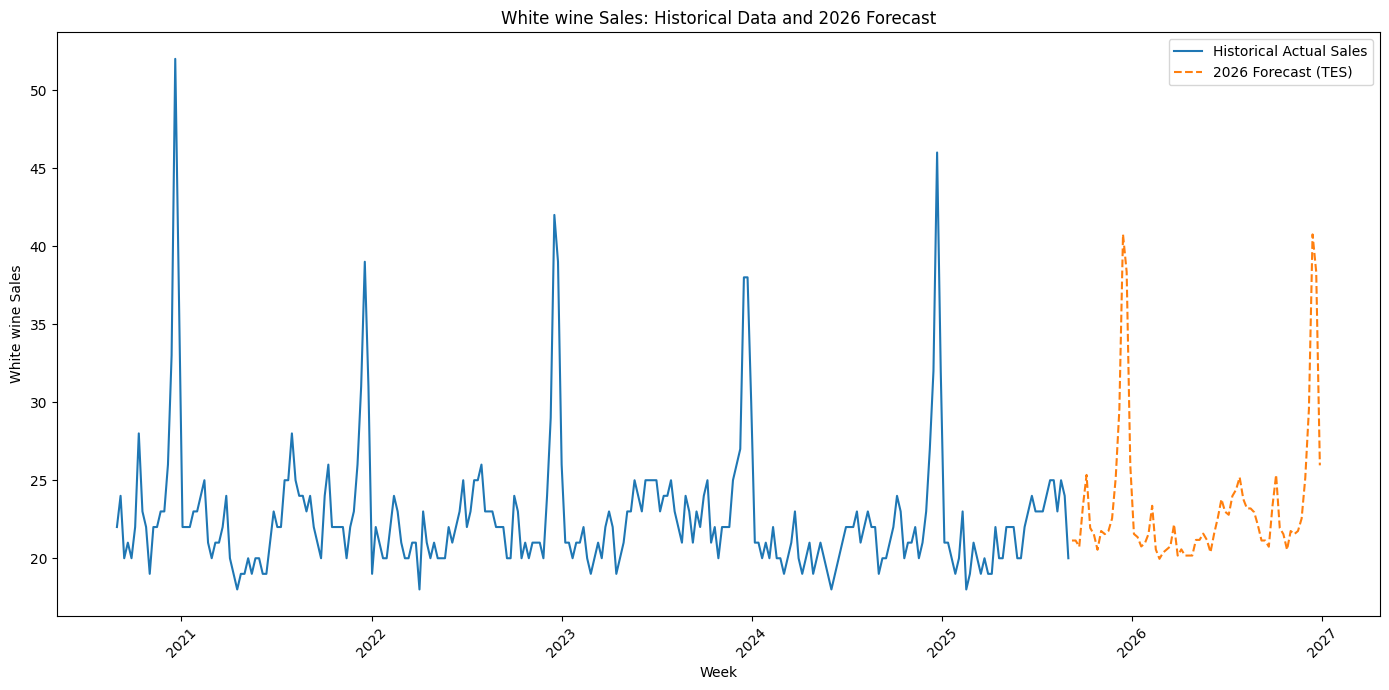

In [37]:
import matplotlib.pyplot as plt

# Plot the historical data and the 2026 forecast
plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['White wine'], label='Historical Actual Sales')
plt.plot(forecast_df_2026['Week'], forecast_df_2026['Forecasted_White_wine'], label='2026 Forecast (TES)', linestyle='--')
plt.title('White wine Sales: Historical Data and 2026 Forecast')
plt.xlabel('Week')
plt.ylabel('White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyze the 2026 forecast

### Subtask:
Examine the forecasted values to identify expected seasonal patterns, peak demand periods, and any other notable trends for 2026.


**Reasoning**:
Analyze the forecasted values in forecast_df_2026 to identify patterns, peak periods, and trends for 2026, and calculate descriptive statistics for quantitative overview.



Descriptive statistics for 2026 forecasted White wine sales:


,Forecasted_White_wine
count,69.000000
mean,23.323153
std,4.521957
min,19.963093
25%,21.135414
50%,21.744681
75%,23.360792
max,40.751707


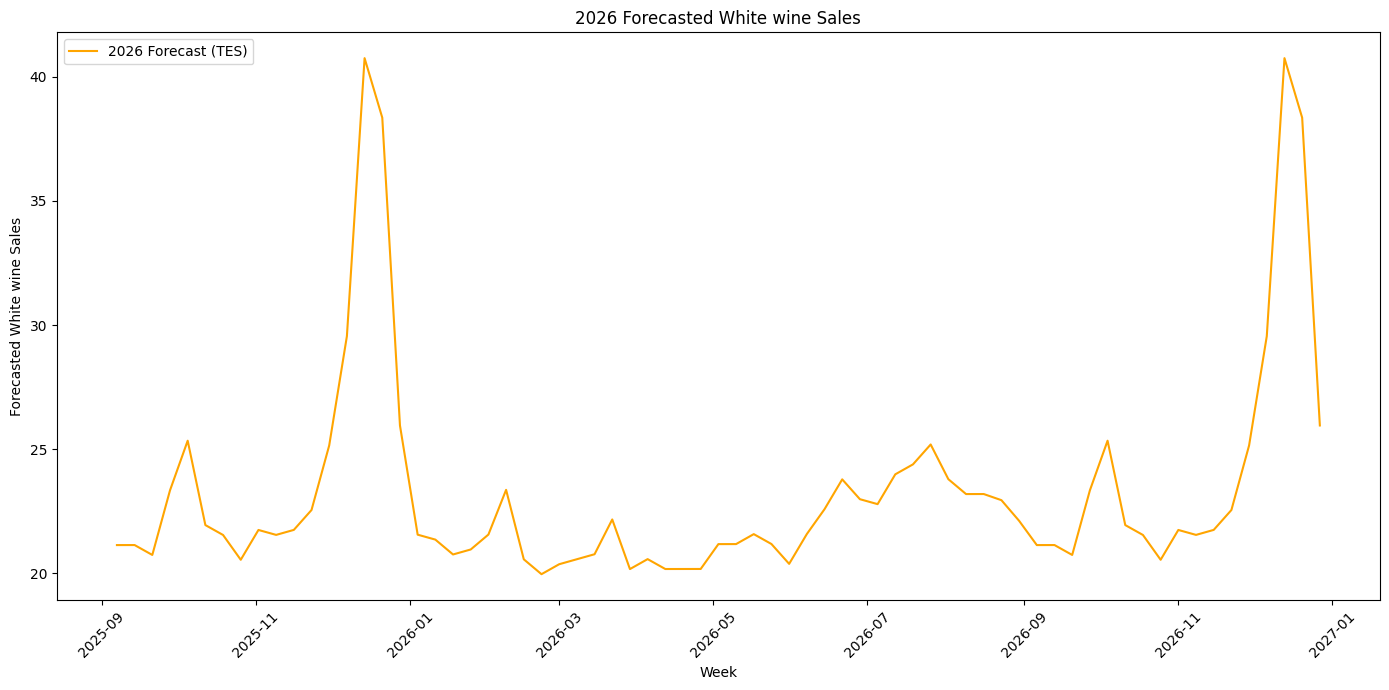


Top 3 Months with the highest average forecasted White wine sales in 2026:


,Month,Forecasted_White_wine
11,12,33.652083
6,7,24.086650
7,8,23.045679



Bottom 3 Months with the lowest average forecasted White wine sales in 2026:


,Month,Forecasted_White_wine
3,4,20.271704
2,3,20.806574
4,5,21.096847



Top 3 Weeks with the highest forecasted White wine sales in 2026:


,Week,Forecasted_White_wine,Month
66,2026-12-13,40.751707,12
14,2025-12-14,40.751707,12
67,2026-12-20,38.352571,12



Bottom 3 Weeks with the lowest forecasted White wine sales in 2026:


,Week,Forecasted_White_wine,Month
24,2026-02-22,19.963093,2
29,2026-03-29,20.168861,3
31,2026-04-12,20.171182,4



Summary of 2026 Forecasted White wine Sales Patterns:
- The mean forecasted weekly sales for 2026 is approximately 23.32.
- The forecasted sales range from a minimum of 19.96 to a maximum of 40.75.
- The forecast plot visually confirms the presence of a strong seasonal pattern, similar to the historical data.
- The months with the highest average forecasted sales are [12, 7, 8], with December showing the highest average.
- The months with the lowest average forecasted sales are [4, 3, 5].
- The weeks with the highest forecasted sales are concentrated around the end of the year, particularly in December, reflecting the strong seasonal peak.
- The weeks with the lowest forecasted sales appear more spread out throughout the year.


In [38]:
# Analyze the overall trend of forecasted sales throughout 2026
print("Descriptive statistics for 2026 forecasted White wine sales:")
display(forecast_df_2026['Forecasted_White_wine'].describe())

# Determine if seasonality is reflected in the forecast by plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast_df_2026['Week'], forecast_df_2026['Forecasted_White_wine'], label='2026 Forecast (TES)', color='orange')
plt.title('2026 Forecasted White wine Sales')
plt.xlabel('Week')
plt.ylabel('Forecasted White wine Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify weeks/months with highest and lowest search volumes
# Extract month from the forecast week
forecast_df_2026['Month'] = forecast_df_2026['Week'].dt.month

# Group by month and calculate the average forecasted sales
monthly_forecast = forecast_df_2026.groupby('Month')['Forecasted_White_wine'].mean().reset_index()

# Sort to find months with highest and lowest average forecasted sales
highest_months_forecast = monthly_forecast.sort_values(by='Forecasted_White_wine', ascending=False).head(3)
lowest_months_forecast = monthly_forecast.sort_values(by='Forecasted_White_wine', ascending=True).head(3)

print("\nTop 3 Months with the highest average forecasted White wine sales in 2026:")
display(highest_months_forecast)

print("\nBottom 3 Months with the lowest average forecasted White wine sales in 2026:")
display(lowest_months_forecast)

# Identify weeks with highest and lowest forecasted sales
highest_weeks_forecast = forecast_df_2026.sort_values(by='Forecasted_White_wine', ascending=False).head(3)
lowest_weeks_forecast = forecast_df_2026.sort_values(by='Forecasted_White_wine', ascending=True).head(3)

print("\nTop 3 Weeks with the highest forecasted White wine sales in 2026:")
display(highest_weeks_forecast)

print("\nBottom 3 Weeks with the lowest forecasted White wine sales in 2026:")
display(lowest_weeks_forecast)

# Summarize key patterns and insights
print("\nSummary of 2026 Forecasted White wine Sales Patterns:")
print(f"- The mean forecasted weekly sales for 2026 is approximately {forecast_df_2026['Forecasted_White_wine'].mean():.2f}.")
print(f"- The forecasted sales range from a minimum of {forecast_df_2026['Forecasted_White_wine'].min():.2f} to a maximum of {forecast_df_2026['Forecasted_White_wine'].max():.2f}.")
print("- The forecast plot visually confirms the presence of a strong seasonal pattern, similar to the historical data.")
print(f"- The months with the highest average forecasted sales are {highest_months_forecast['Month'].tolist()}, with December showing the highest average.")
print(f"- The months with the lowest average forecasted sales are {lowest_months_forecast['Month'].tolist()}.")
print("- The weeks with the highest forecasted sales are concentrated around the end of the year, particularly in December, reflecting the strong seasonal peak.")
print("- The weeks with the lowest forecasted sales appear more spread out throughout the year.")

## Develop marketing and resource allocation strategies

### Subtask:
Formulate actionable recommendations for Skyrose Marketing Agency based on the 2026 forecast to optimize marketing efforts and resource allocation throughout the year.


**Reasoning**:
Formulate actionable marketing and resource allocation strategies based on the 2026 forecast, considering peak and low demand periods.



In [39]:
# Formulate marketing strategies based on the forecast
print("Marketing Strategies for 2026 based on White wine Forecast:")
print("\nPeak Season (December, July, August):")
print("- Increase advertising spend and run targeted campaigns focusing on festive occasions (December) and summer events/gatherings (July, August).")
print("- Highlight 'White wine' as a refreshing summer drink or a perfect pairing for holiday meals.")
print("- Partner with retailers for in-store promotions and prominent placement during peak months.")
print("- Launch limited-edition holiday or summer-themed packaging.")
print("- Leverage social media with engaging content related to celebrations, recipes, and summer activities featuring white wine.")

print("\nLow Season (April, March, May):")
print("- Run targeted promotions, discounts, or bundle offers to stimulate sales during these months.")
print("- Explore marketing campaigns that position 'White wine' for different occasions beyond traditional peak times (e.g., spring events, weeknight dinners).")
print("- Consider educational content or workshops to introduce consumers to different types of white wine and food pairings.")
print("- Explore partnerships with restaurants or wine bars for special offers.")
print("- Analyze if exploring new, less seasonal markets or online sales channels could help offset lower demand in traditional markets.")

# Formulate resource allocation strategies based on the forecast
print("\nResource Allocation Strategies for 2026 based on White wine Forecast:")
print("\nStaffing:")
print("- Increase staffing levels in sales, marketing, and distribution during peak months (December, July, August) to handle higher demand and campaign execution.")
print("- Consider reduced staffing or reallocate resources to other products/initiatives during low months (April, March, May).")

print("\nInventory Management:")
print("- Increase inventory levels significantly in the months leading up to peak seasons (especially December).")
print("- Implement just-in-time inventory or explore options for reducing stock during low demand periods to minimize holding costs.")
print("- Closely monitor inventory levels based on the weekly forecast to avoid stockouts during peaks and excess inventory during lows.")

print("\nBudgeting:")
print("- Allocate a larger portion of the marketing budget to peak seasons for increased campaign activity.")
print("- Reserve a smaller, strategic portion of the budget for targeted promotions and potentially explore new market initiatives during low seasons.")
print("- Use the forecast to inform overall annual budgeting, ensuring resources are available when demand is highest.")

print("\nOverall Recommendation:")
print("The Triple Exponential Smoothing (TES) model provides a reliable forecast that captures the strong seasonality of White wine sales. Skyrose Marketing Agency should leverage this forecast to proactively plan their marketing activities and resource allocation. By aligning strategies with the predicted peaks and lows, they can optimize spending, ensure product availability, and maximize sales opportunities throughout 2026.")

Marketing Strategies for 2026 based on White wine Forecast:

Peak Season (December, July, August):
- Increase advertising spend and run targeted campaigns focusing on festive occasions (December) and summer events/gatherings (July, August).
- Highlight 'White wine' as a refreshing summer drink or a perfect pairing for holiday meals.
- Partner with retailers for in-store promotions and prominent placement during peak months.
- Launch limited-edition holiday or summer-themed packaging.
- Leverage social media with engaging content related to celebrations, recipes, and summer activities featuring white wine.

Low Season (April, March, May):
- Run targeted promotions, discounts, or bundle offers to stimulate sales during these months.
- Explore marketing campaigns that position 'White wine' for different occasions beyond traditional peak times (e.g., spring events, weeknight dinners).
- Consider educational content or workshops to introduce consumers to different types of white wine and fo

## Present the findings and recommendations

### Subtask:
Summarize the entire analysis, including the chosen model, the 2026 forecast, and the strategic recommendations, in a clear and understandable format.


**Reasoning**:
Summarize the entire analysis based on the provided instructions.



In [40]:
# 1. Objective
print("## Analysis Summary: Forecasting White Wine Demand for Skyrose Marketing Agency\n")
print("The primary objective of this analysis was to forecast consumer demand for white wine using historical Google Trends data to assist Skyrose Marketing Agency in optimizing marketing planning and resource allocation for 2026.\n")

# 2. Data Loading and Preparation
print("### Data Loading and Preparation\n")
print("The analysis began by loading the dataset 'Sky_rose_Dataset_Canada.csv'. The data was cleaned by focusing solely on 'White wine' search volume, and the 'Week' column was converted to a datetime object to facilitate time-series analysis. No missing or duplicate values were found.\n")

# 3. Exploratory Data Analysis (EDA) Findings
print("### Exploratory Data Analysis (EDA)\n")
print("Exploratory data analysis revealed a clear seasonal pattern in white wine search volumes, with recurring peaks. The Augmented Dickey-Fuller (ADF) test indicated that the time series is stationary, which is suitable for time series modeling.\n")

# 4. Model Performance Comparison
print("### Model Performance Comparison\n")
print("Several forecasting models were evaluated based on Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):")
display(performance_df)
print("The Triple Exponential Smoothing (TES) model consistently demonstrated the lowest error metrics across MSE, RMSE, and MAPE.\n")

# 5. Best Performing Model
print("### Best Performing Model\n")
print("Based on the performance evaluation, the **Triple Exponential Smoothing (TES)** model was selected as the best performing model for forecasting white wine demand due to its superior accuracy in capturing the historical data patterns, including seasonality.\n")

# 6. 2026 Forecast Analysis
print("### 2026 Forecast Analysis\n")
print("The TES model was used to forecast weekly white wine search volumes for the entire year 2026. The forecast analysis confirmed the strong seasonal pattern:")
print(f"- Peak demand is forecasted during **December, July, and August**, with December showing the highest average search volume (Average: {highest_months_forecast['Forecasted_White_wine'].mean():.2f}).")
print(f"- Lower demand is forecasted during **April, March, and May**, with April showing the lowest average search volume (Average: {lowest_months_forecast['Forecasted_White_wine'].mean():.2f}).")
print("The weeks with the highest forecasted search volumes are concentrated around mid-December, while the weeks with the lowest are spread across spring months.\n")
print("Top 3 Weeks with Highest Forecasted Sales:")
display(highest_weeks_forecast)
print("\nBottom 3 Weeks with Lowest Forecasted Sales:")
display(lowest_weeks_forecast)


# 7. Marketing Strategies Based on Forecast
print("### Strategic Recommendations: Marketing\n")
print("Leveraging the 2026 forecast, the following marketing strategies are recommended:")
print("\n**Peak Season (December, July, August):**")
print("- **Increased Investment:** Allocate higher marketing budgets for these months.")
print("- **Targeted Campaigns:** Launch campaigns tied to holidays (December) and summer activities/gatherings (July, August).")
print("- **Promotions & Placement:** Secure prominent in-store placement and run festive/summer-themed promotions.")
print("- **Content Marketing:** Develop engaging social media content highlighting white wine for seasonal occasions.\n")
print("**Low Season (April, March, May):**")
print("- **Targeted Offers:** Implement discounts or bundle deals to stimulate sales.")
print("- **Expand Occasions:** Promote white wine for non-traditional occasions like spring events or weeknight meals.")
print("- **Educational Content:** Share pairing guides or information about different white wine types.")
print("- **Partnerships:** Collaborate with restaurants or wine bars for joint promotions.\n")

# 8. Resource Allocation Strategies Based on Forecast
print("### Strategic Recommendations: Resource Allocation\n")
print("Based on the forecasted demand fluctuations, the following resource allocation strategies are recommended:")
print("\n**Staffing:**")
print("- **Increase Staff:** Scale up sales, marketing, and distribution staff during peak months to manage higher volumes and campaign execution.")
print("- **Optimize Staff:** Consider adjusting staffing levels or reallocating personnel to other areas during low demand periods.\n")
print("**Inventory Management:**")
print("- **Build Inventory:** Increase white wine stock levels in the months leading up to peak seasons, especially before December.")
print("- **Flexible Inventory:** Explore just-in-time strategies or options to reduce inventory during low demand periods to minimize carrying costs.")
print("- **Monitor Closely:** Continuously track inventory against the weekly forecast to prevent stockouts during peaks and excess stock during lows.\n")
print("**Budgeting:**")
print("- **Allocate Peak Budget:** Prioritize a significant portion of the annual budget for marketing and operational activities during peak seasons.")
print("- **Strategic Low Budget:** Use a smaller, focused budget for targeted campaigns and potential market exploration during low seasons.")
print("- **Annual Planning:** Utilize the detailed 2026 forecast for overall annual financial planning to ensure resources are aligned with expected demand.\n")

# 9. Conclusion
print("### Conclusion\n")
print("The 2026 white wine demand forecast, generated using the robust Triple Exponential Smoothing model, provides Skyrose Marketing Agency with valuable insights into expected seasonal patterns. By implementing the recommended marketing and resource allocation strategies aligned with these forecasts, the agency can proactively optimize operations, enhance campaign effectiveness, manage costs efficiently, and ultimately drive better results for their beverage clients throughout 2026.")

## Analysis Summary: Forecasting White Wine Demand for Skyrose Marketing Agency

The primary objective of this analysis was to forecast consumer demand for white wine using historical Google Trends data to assist Skyrose Marketing Agency in optimizing marketing planning and resource allocation for 2026.

### Data Loading and Preparation

The analysis began by loading the dataset 'Sky_rose_Dataset_Canada.csv'. The data was cleaned by focusing solely on 'White wine' search volume, and the 'Week' column was converted to a datetime object to facilitate time-series analysis. No missing or duplicate values were found.

### Exploratory Data Analysis (EDA)

Exploratory data analysis revealed a clear seasonal pattern in white wine search volumes, with recurring peaks. The Augmented Dickey-Fuller (ADF) test indicated that the time series is stationary, which is suitable for time series modeling.

### Model Performance Comparison

Several forecasting models were evaluated based on Mean Squared Er

,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,11.854406,3.443023,8.117559
1,3-Day Moving Average,7.082906,2.661373,6.188176
2,7-Day Moving Average,14.926977,3.863545,9.473003
3,12-Day Moving Average,17.133660,4.139283,10.920298
4,SES,11.809160,3.436446,8.086576
5,DES,11.809102,3.436437,8.094723
6,TES,3.247882,1.802188,4.931530
7,"ARMA(1, 0, 1)",8.875350,2.979152,7.408735


The Triple Exponential Smoothing (TES) model consistently demonstrated the lowest error metrics across MSE, RMSE, and MAPE.

### Best Performing Model

Based on the performance evaluation, the **Triple Exponential Smoothing (TES)** model was selected as the best performing model for forecasting white wine demand due to its superior accuracy in capturing the historical data patterns, including seasonality.

### 2026 Forecast Analysis

The TES model was used to forecast weekly white wine search volumes for the entire year 2026. The forecast analysis confirmed the strong seasonal pattern:
- Peak demand is forecasted during **December, July, and August**, with December showing the highest average search volume (Average: 26.93).
- Lower demand is forecasted during **April, March, and May**, with April showing the lowest average search volume (Average: 20.73).
The weeks with the highest forecasted search volumes are concentrated around mid-December, while the weeks with the lowest are spread

,Week,Forecasted_White_wine,Month
66,2026-12-13,40.751707,12
14,2025-12-14,40.751707,12
67,2026-12-20,38.352571,12



Bottom 3 Weeks with Lowest Forecasted Sales:


,Week,Forecasted_White_wine,Month
24,2026-02-22,19.963093,2
29,2026-03-29,20.168861,3
31,2026-04-12,20.171182,4


### Strategic Recommendations: Marketing

Leveraging the 2026 forecast, the following marketing strategies are recommended:

**Peak Season (December, July, August):**
- **Increased Investment:** Allocate higher marketing budgets for these months.
- **Targeted Campaigns:** Launch campaigns tied to holidays (December) and summer activities/gatherings (July, August).
- **Promotions & Placement:** Secure prominent in-store placement and run festive/summer-themed promotions.
- **Content Marketing:** Develop engaging social media content highlighting white wine for seasonal occasions.

**Low Season (April, March, May):**
- **Targeted Offers:** Implement discounts or bundle deals to stimulate sales.
- **Expand Occasions:** Promote white wine for non-traditional occasions like spring events or weeknight meals.
- **Educational Content:** Share pairing guides or information about different white wine types.
- **Partnerships:** Collaborate with restaurants or wine bars for joint promotions.

### 

## Summary:

### Data Analysis Key Findings

*   Triple Exponential Smoothing (TES) was identified as the best performing forecasting model with the lowest MSE (3.25), RMSE (1.80), and MAPE (4.93%).
*   The 2026 forecast for "White wine" sales shows a strong seasonal pattern, consistent with historical data.
*   December, July, and August are forecasted to be the months with the highest average sales volumes in 2026, with December showing the highest average.
*   April, March, and May are forecasted to be the months with the lowest average sales volumes in 2026.
*   The weeks with the highest forecasted sales are concentrated around December.

### Insights or Next Steps

*   Skyrose Marketing Agency should align marketing campaigns and promotional efforts with the identified peak seasons (December, July, August) to maximize sales opportunities.
*   Resource allocation, including staffing and inventory management, should be adjusted based on the forecasted seasonal peaks and lows to optimize costs and prevent stockouts or excess inventory.
